### Bar Crawl Exercise


## Setup

Import packages and load data. I used {get reference] to convert the original .csv files into .ftr (feather) to reduce size and load times. 

In [1]:
import opendatasets as od

import numpy as np
import pandas as pd

from scipy.signal import spectrogram
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

from os import listdir, walk, environ
from os.path import isfile, join, exists

import re as re

In [2]:
import sys

## Fetch data and convert types

 - get data from Kaggle
 - create data folder
 - reduce memory usage (see citation for borrowed code snippet)
 - convert .csv to .ftr (feather) for faster loading in future runs


In [3]:
if not exists('./feather_data'):
    od.download("https://www.kaggle.com/datasets/nautiyalamit/bar-crawl-detecting-heavy-drinking-data-set")

In [4]:
# The code in this cell is credited to 
# https://gist.github.com/fujiyuu75/748bc168c9ca8a49f86e144a08849893

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
# kaggle datasets download -d nautiyalamit/bar-crawl-detecting-heavy-drinking-data-set

In [6]:
datafolder = 'feather_data'
acc_datafile = 'all_accelerometer_data_pids_13.ftr'
phone_datafile = 'phone_types.ftr'

all_acc_df = pd.read_feather(join(datafolder, acc_datafile))
phones_df = pd.read_feather(join(datafolder, phone_datafile))

In [7]:
phones_df

,pid,phonetype
0,BK7610,iPhone
1,BU4707,iPhone
2,CC6740,Android
3,DC6359,iPhone
4,DK3500,iPhone
5,HV0618,iPhone
6,JB3156,Android
7,JR8022,iPhone
8,MC7070,iPhone
9,MJ8002,iPhone


In [8]:
# make a dictionary of TAC files with keys being subject PIDs
# # pattern = re.compile(r'\D{2}\d{4}')
# pattern = re.compile(r'\D{2}\d{4}')
# tac_files = [filename if re.match(r'\D{2}\d{4}',filename) for filename in listdir(datafolder)].sort()

tac_files = sorted([filename for filename in listdir(datafolder) if re.match(r'\D{2}\d{4}',filename)])
pid_list = [filename[0:6] for filename in tac_files]

tac_df = {}

for tac_file in tac_files:
    pid = tac_file[0:6]
    if tac_file.endswith('.ftr'):
        tac_df[pid] = pd.read_feather(join(datafolder, tac_file))
    elif tac_file.endswith('.csv'):
        tac_df[pid] = pd.read_csv(join(datafolder, tac_file))
    else:
        print('%s is neither a .csv or .ftr' % tac_file)

In [9]:
acc_df = {}

for pid in pid_list:
    acc_df[pid] = all_acc_df[all_acc_df.pid==pid].reset_index().drop(columns = 'index')

## Initial inspection

Notes:

 - acceleration time stamps in milliseconds sampled nominally at 40 Hz
 - some subjects' acceleration data starts with a spurious zero reading
 - TAC time stamps in seconds

In [10]:
for pid in pid_list:
    print(acc_df[pid].head(2))

            time     pid         x       y       z
0  1493735870653  BK7610  0.126099 -0.0078 -0.0243
1  1493735870679  BK7610  0.133545 -0.0697 -0.0446
            time     pid         x       y       z
0  1493737404780  BU4707 -0.009399  0.0147  0.0186
1  1493737404807  BU4707 -0.000100  0.0126  0.0168
            time     pid         x         y         z
0              0  CC6740  0.000000  0.000000  0.000000
1  1493740580198  CC6740  0.019653 -0.007789  0.168013
            time     pid         x       y       z
0  1493736440950  DC6359  0.000300 -0.0001  0.0038
1  1493736440969  DC6359  0.004501 -0.0085 -0.0069
            time     pid       x       y       z
0  1493744709881  DK3500  0.0000  0.0021  0.0153
1  1493744709905  DK3500 -0.0014  0.0003  0.0145
            time     pid         x       y       z
0  1493738907489  HV0618  0.010399  0.0098  0.0149
1  1493738907513  HV0618 -0.014801 -0.0178  0.0066
            time     pid         x         y          z
0              0  JB

In [11]:
for pid in pid_list:
    print(tac_df[pid].head(2))

    timestamp  TAC_Reading
0  1493718714    -0.000482
1  1493720697     0.001573
    timestamp  TAC_Reading
0  1493718714    -0.000482
1  1493720697     0.001573
    timestamp  TAC_Reading
0  1493723434     0.003948
1  1493725257     0.000898
    timestamp  TAC_Reading
0  1493719224    -0.002079
1  1493721045     0.000898
    timestamp  TAC_Reading
0  1493727820     0.000215
1  1493728019     0.001716
    timestamp  TAC_Reading
0  1493721779    -0.001077
1  1493723604     0.004120
    timestamp  TAC_Reading
0  1493722816     0.002388
1  1493724639     0.000271
    timestamp  TAC_Reading
0  1493721062     0.000068
1  1493722885    -0.012199
    timestamp  TAC_Reading
0  1493719652    -0.003151
1  1493721476     0.000554
    timestamp  TAC_Reading
0  1493720054    -0.001385
1  1493721878     0.000864
    timestamp  TAC_Reading
0  1493717859     0.000043
1  1493720213     0.003820
    timestamp  TAC_Reading
0  1493716723    -0.010231
1  1493718546    -0.002512
    timestamp  TAC_Reading
0

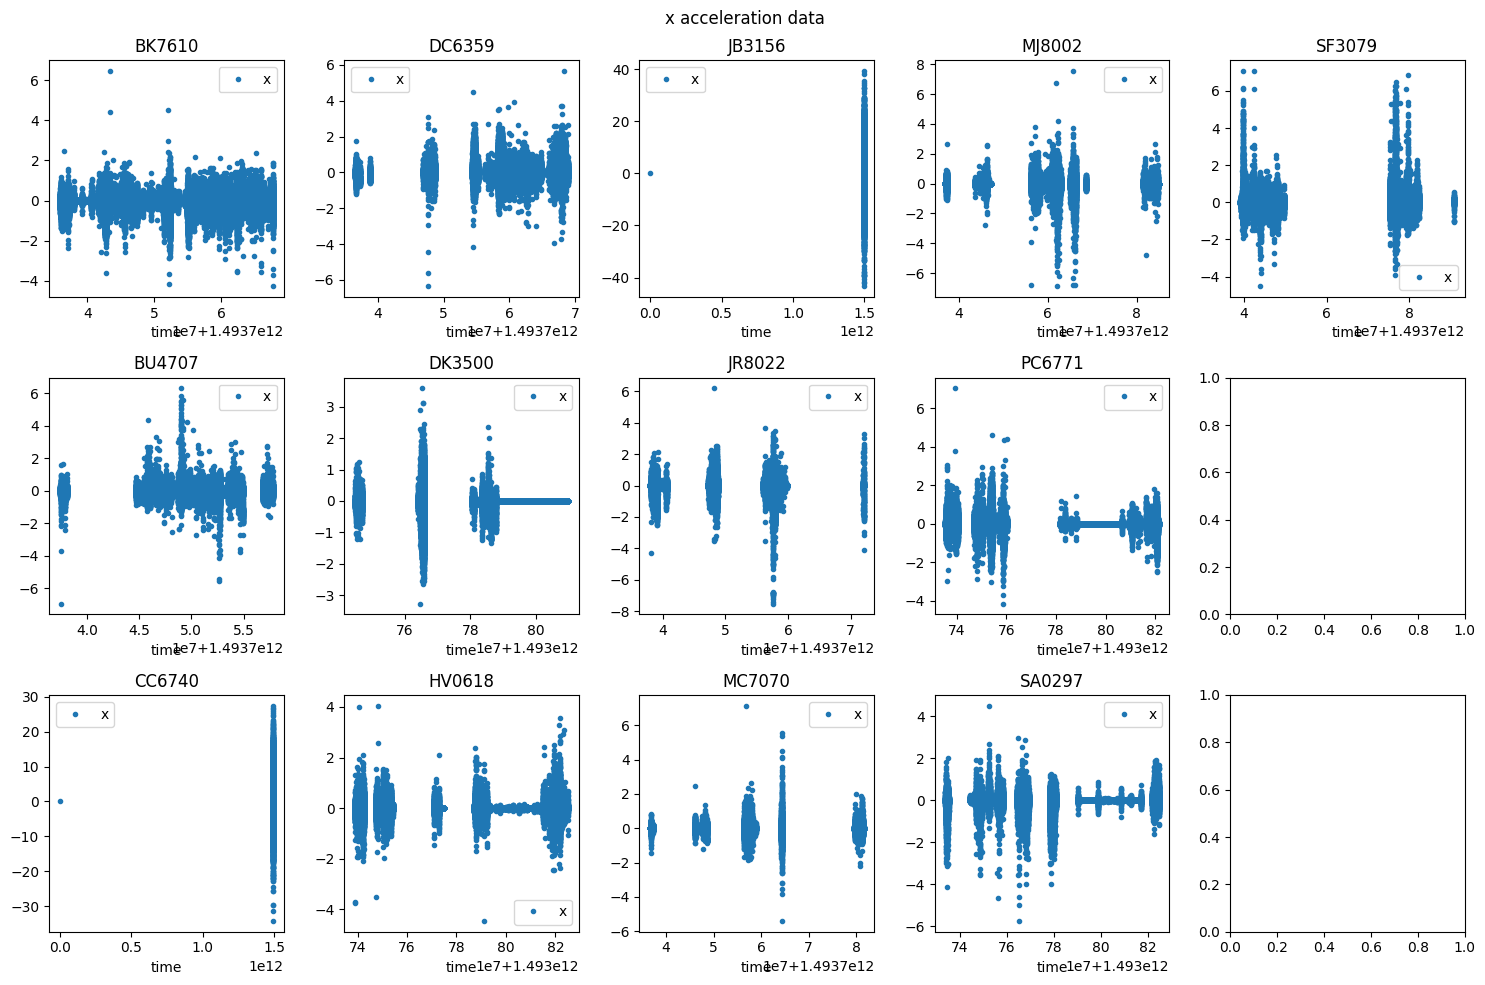

In [12]:
fig, ax = plt.subplots(3,5, figsize=(15,10))


for k, pid in enumerate(pid_list):
    acc_df[pid].plot(x='time', y = 'x', marker = '.', linestyle = 'none', ax = ax[k%3, int(np.floor(k/3))])
    ax[k%3, int(np.floor(k/3))].set_title(pid)
    
fig.suptitle('x acceleration data')
plt.tight_layout()
plt.show()

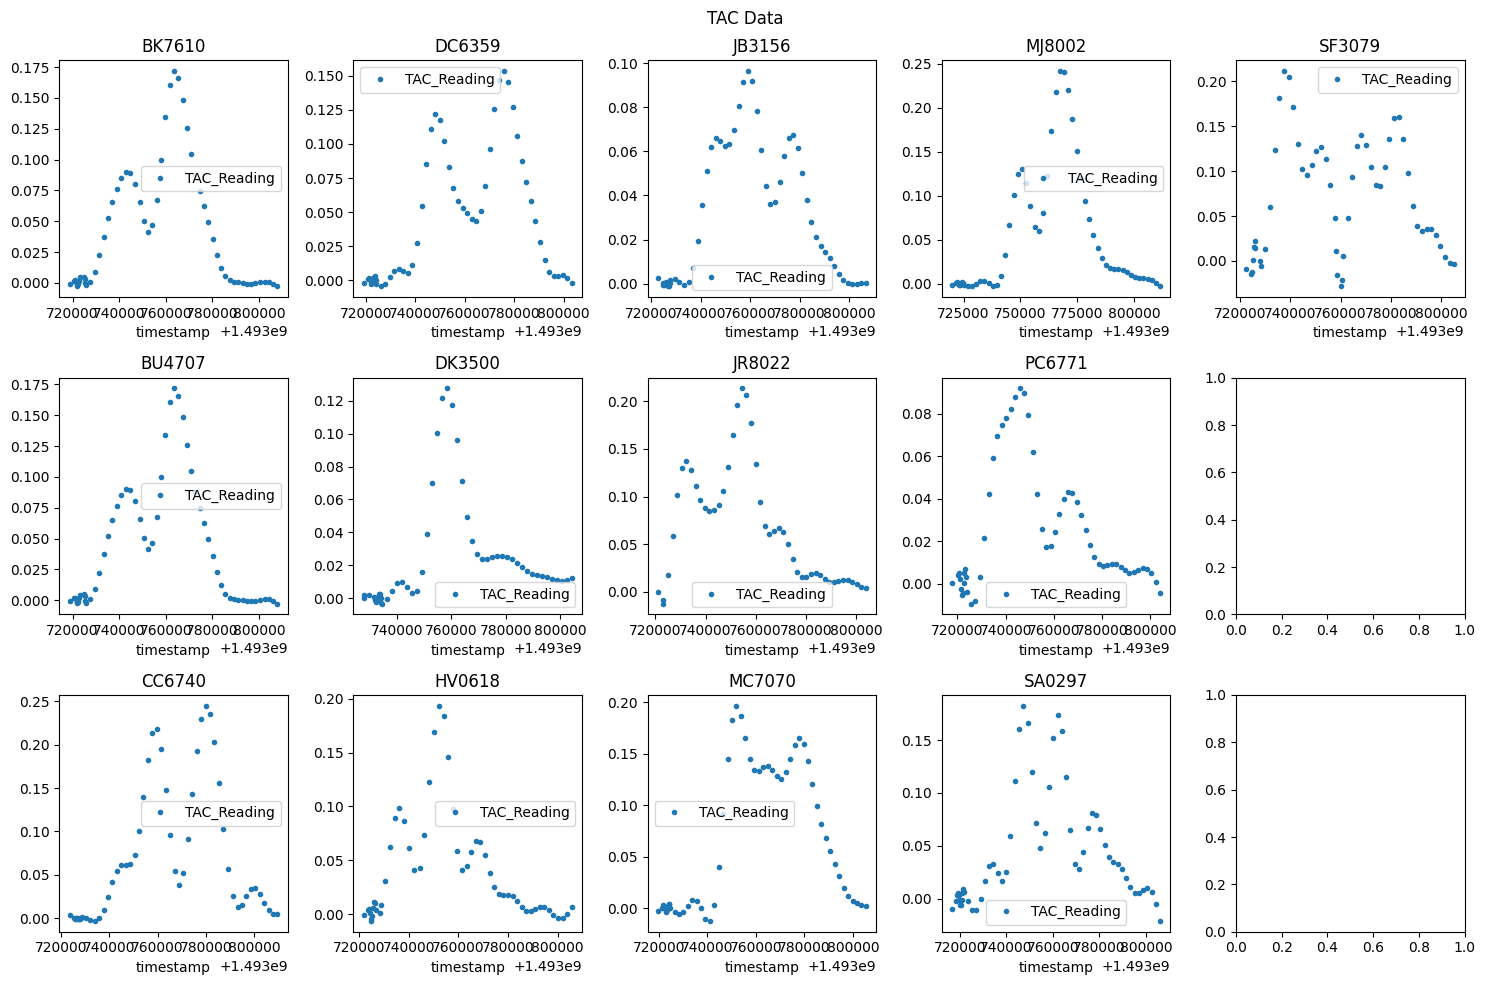

In [13]:
fig, ax = plt.subplots(3,5, figsize=(15,10))


for k, pid in enumerate(pid_list):
    tac_df[pid].plot(x='timestamp', y = 'TAC_Reading', marker = '.', linestyle = 'none', ax = ax[k%3, int(np.floor(k/3))])
    ax[k%3, int(np.floor(k/3))].set_title(pid)
    
fig.suptitle('TAC Data')
plt.tight_layout()
plt.show()

#### Observations

 - every subject has patches of missing data
 - subjects JB3156, CC6740, and possibly others are unusable. Possibly coincidentally, the Android phone using subjects were the ones with bad accelerometer data 
 - TAC data looks okay

## Clean up and transforming data

 - Remove unusable subject data
 - Convert accelerometer time to seconds and resample TAC to align with accelerometer timestamps
 - Snip out 8 sec clips. Why 8 sec? We're attempting to infer blood alcohol levels from accelerations induced by the subjects' movement patterns. If the acceleration data encodes bouts of walking, a rhythmic behavior, the frequency content of acceleration signals could be useful. Typically, h Most notably,  though we may also find accelerations suggesting the subject has fallen or dropped their phone.


In [14]:
pid_remove = ['JB3156', 'CC6740']

for pid in pid_remove:
    if pid in pid_list:
        pid_list.remove(pid)
    acc_df.pop(pid, None)
    tac_df.pop(pid, None)

In [15]:
for pid in pid_list:
    try:
        tac_df[pid].rename(columns={'timestamp':'time_s'}, inplace=True)
        acc_df[pid]['time_s'] = acc_df[pid]['time'].to_numpy()/1000
        del acc_df[pid]['time']
    except:
        print('already been done')
    
    linear_interp = interp1d(tac_df[pid]['time_s'].to_numpy(), tac_df[pid]['TAC_Reading'], kind='linear', axis=0, bounds_error=False)
    acc_df[pid]['tac'] = linear_interp(acc_df[pid]['time_s'].to_numpy())
    
    tac_df[pid]['time_s'] = tac_df[pid]['time_s'].to_numpy() - acc_df[pid]['time_s'][0]
    acc_df[pid]['time_s'] = acc_df[pid]['time_s'].to_numpy() - acc_df[pid]['time_s'][0]


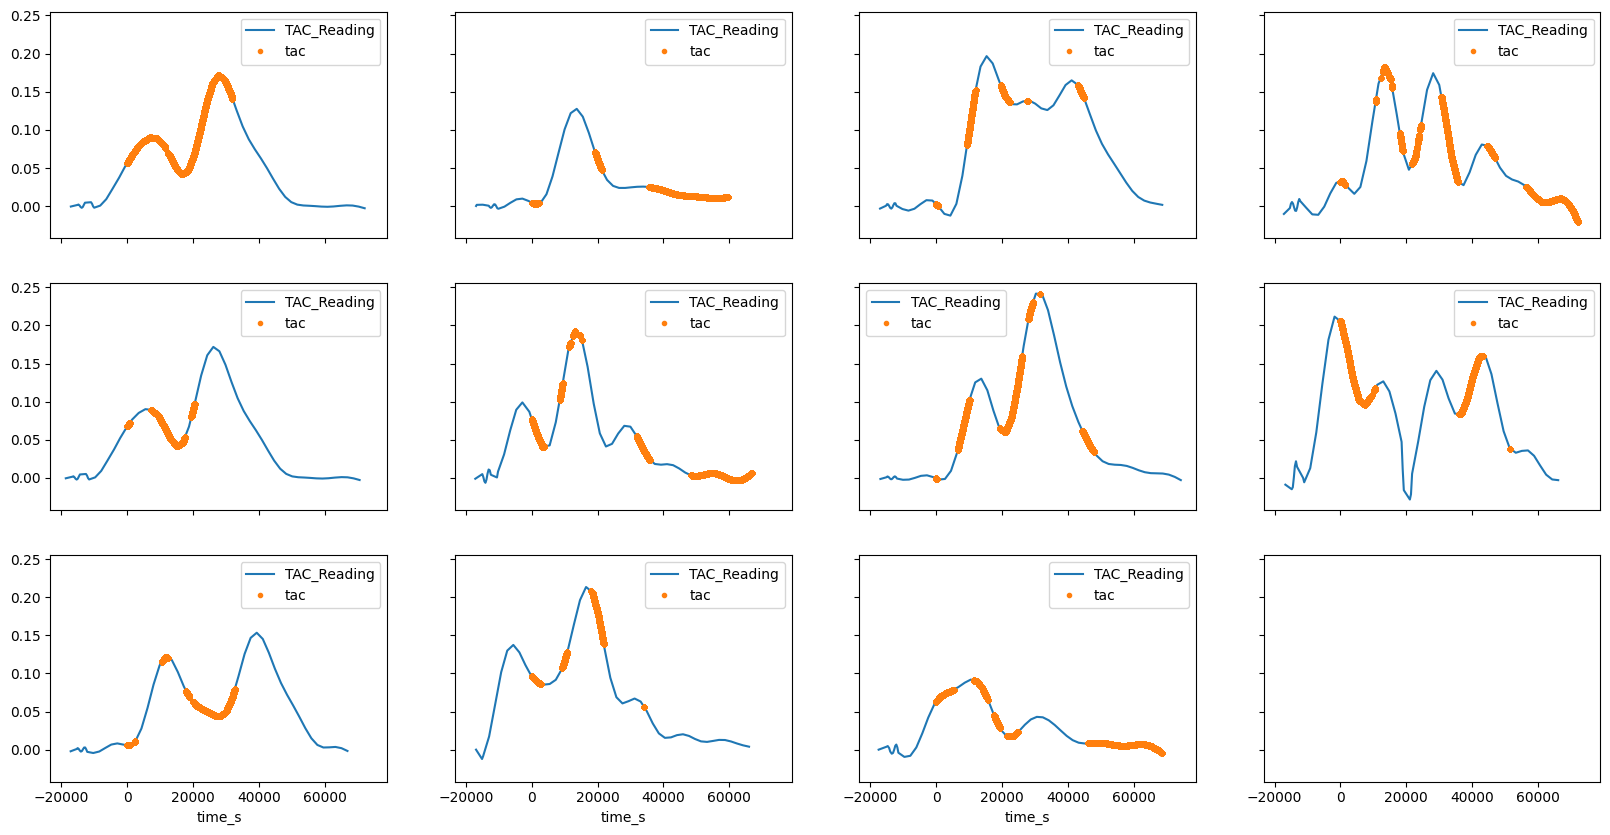

In [17]:
fig, ax = plt.subplots(3,4, figsize=(20, 10), sharex=True, sharey=True)

for k, pid in enumerate(pid_list):
    tac_df[pid].plot(x='time_s', y = 'TAC_Reading', ax = ax[k%3, int(np.floor(k/3))])
    acc_df[pid].plot(x='time_s', y = 'tac', ax = ax[k%3, int(np.floor(k/3))], marker = '.', linestyle = 'none')

plt.show()

Explain windowing. overlap = 0.5

In [49]:
win_sec = 8  # sliding window in seconds
win = win_sec * 40   # sliding window size in number of samples
win_34 = int(3*win/4)

sample = []
for pid in pid_list:
    gap_idx = np.argwhere([np.diff(acc_df[pid].time_s)>0.25])[:,1]
    print(gap_idx)
    gap_idx = np.append(np.array([0]), gap_idx)

    gap_pairs = np.vstack((gap_idx[0:-2], gap_idx[1:-1])).transpose()
    gap_sizes = np.squeeze(np.diff(gap_pairs, axis=1))
    for k, gap in enumerate(gap_sizes):
        if gap>win:
            start_idx = int(((gap%(win_34))/2) + gap_idx[k])
            while (start_idx + win) < gap_pairs[k, 1]:
                sample.append(acc_df[pid].iloc[start_idx:(start_idx+win)].reset_index())
                start_idx += win_34

[   1997   11982   14979   45948  295693  329018  338644  452525  730238
  801167  939022  940021 1017940]
[  1997  11984  12260  13961  14270  14967  16921  23914  56462 344542
 353533 361525 364522 372514 373513 407337 407478]
[  2996  15411  15643  15971  76908  77907  78906  79905  80685  84899
 114868 189791 216761 302671 333640 485908 489473 517439 571382]
[   998   5992   6988  86901 167814]
[   2996    3995   28968   30966   32963   33962   38957   39956   41954
  136855  142848  158832  165825  166821  178809  182802  188629  192792
  194790  195789  202782  209771  214766  215765  382589  411353  785132
 1744150 1824064 1847041 1855033 1867021 1868020]
[  1997   2247   7749  10658  10684  17948  24938 101751 101827 101976
 155751 160745 162743 212080 219666 270748 272002 305968]
[  2996   3995  21975 124745 124819 231707 242695 242830]
[  1997   5988  12978 155824 428531 485470 488465]
[   2996   15977  161800  207752  207805  210131  282647  298628  299627
  347579  349577  

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (20, 2))
plt.plot(acc_df[pid].time, np.ones(np.size(acc_df[pid].time)), '.')
plt.plot(acc_df[pid]['time'].iloc[gap_idx], np.ones(len(gap_idx)), '.')

#plt.plot(np.diff(acc_df[pid].time))
print(pid)

In [ ]:
acc_df[pid].time[gap_idx[1:-1]]

In [50]:
len(sample)

35261